# Data Preprocessing for Soft Sensor

## Read and Generate Data

In [42]:
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import scipy.io as scio


def load_mat_data(file_path: Path, variables: List[str]) -> List[np.ndarray]:
    data = scio.loadmat(file_path)
    return [data[var] for var in variables]

def split_data(data: np.ndarray, train_ratio: float=0.6, valid_ratio: float=0.2) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    total_size = data.shape[0]
    train_end = int(total_size * train_ratio)
    valid_end = int(total_size * (train_ratio + valid_ratio))

    train_data = data[:train_end]
    valid_data = data[train_end:valid_end]
    test_data = data[valid_end:]

    return train_data, valid_data, test_data

def preprocess_data(data_t1: np.ndarray, data_t2: np.ndarray, data_t3: np.ndarray, output_var: int = 9) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    train_t1, valid_t1, test_t1 = split_data(data_t1)
    train_t2, valid_t2, test_t2 = split_data(data_t2)
    train_t3, valid_t3, test_t3 = split_data(data_t3)

    training_set = np.vstack((train_t1, train_t2, train_t3))
    validation_set = np.vstack((valid_t1, valid_t2, valid_t3))
    testing_set = np.vstack((test_t1, test_t2, test_t3))

    # Define indices to remove
    # idx_var_remove = list(set([output_var - 1, -1]))  # why we need to remove the last feature? 
    idx_var_remove = list(set([output_var - 1]))

    X_train, Y_train = np.delete(training_set, idx_var_remove, axis=1), training_set[:, output_var-1]
    X_valid, Y_valid = np.delete(validation_set, idx_var_remove, axis=1), validation_set[:, output_var-1]
    X_test, Y_test = np.delete(testing_set, idx_var_remove, axis=1), testing_set[:, output_var-1]

    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test


data_dir = Path("..")/"Datasets"/"CVACaseStudy"/"MFP"/"Training.mat"
data_t1, data_t2, data_t3 = load_mat_data(data_dir, ["T1", "T2", "T3"])
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = preprocess_data(data_t1, data_t2, data_t3)

In [ ]:
def get_norm_param(x: np.ndarray, y: np.ndarray) -> Dict[str, np.ndarray]:
    keys = ['x_min','x_max','y_min','y_max','x_mean','x_std','y_mean','y_std']
    norm_param = {}
    for key in keys: 
        norm_param[key] = []
    
    norm_param['x_min']  = np.min(x, axis=0)
    norm_param['x_max']  = np.max(x, axis=0)
    norm_param['y_min']  = np.min(y, axis=0)
    norm_param['y_max']  = np.max(y, axis=0)
    norm_param['x_mean'] = np.mean(x, axis=0)
    norm_param['x_std']  = np.std(x, axis=0)
    norm_param['y_mean'] = np.mean(y, axis=0)
    norm_param['y_std']  = np.std(y, axis=0)

    return norm_param

def normalize(x: np.ndarray, y: np.ndarray, norm_param: Dict[str, np.ndarray], method: str) -> Tuple[np.ndarray, np.ndarray]: 
    if method == 'minmax':
        X_norm = (x - norm_param['x_min']) / (norm_param['x_max'] - norm_param['x_min'])
        Y_norm = (y - norm_param['y_min']) / (norm_param['y_max'] - norm_param['y_min'])
    elif method == 'standardize':
        X_norm = (x - norm_param['x_mean']) / norm_param['x_std']
        Y_norm = (y - norm_param['y_mean']) / norm_param['y_std']
    else:
        raise TypeError("Normalization method not known")
    
    # other norm methods can be added

    return X_norm, Y_norm


norm_param_train = get_norm_param(X_train, Y_train)
norm_method = "minmax"
X_train_norm, Y_train_norm = normalize(X_train, Y_train, norm_param_train, norm_method)
X_valid_norm, Y_valid_norm = normalize(X_valid, Y_valid, norm_param_train, norm_method)
X_test_norm, Y_test_norm = normalize(X_test, Y_test, norm_param_train, norm_method)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, history_length: int, pred_length: int, pred_mode: str):
        self.x = X
        self.y = Y
        self.history_length = history_length
        self.pred_length = pred_length
        self.mode = pred_mode

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        current_step: predicts the target value for the immediate next time step based on the historical input data.
	    multi_step: predicts multiple future time steps (a sequence) based on the historical input data.
        """
        x = self.x[index : index + self.history_length]

        if self.mode == 'current_step':
            y = self.y[index + self.history_length - 1]  # Predict the next step (current step)
            y = torch.Tensor([y])
        elif self.mode == 'multi_step':
            y = self.y[index + self.history_length : index + self.history_length + self.pred_length]  # Predict multiple future steps
            y = torch.Tensor(y)
        else:
            raise ValueError("Invalid prediction mode.")

        return torch.Tensor(x), y

    def __len__(self) -> int:
        if self.mode == 'current_step':
            return len(self.x) - self.history_length + 1
        elif self.mode == 'multi_step':
            return len(self.x) - self.history_length - self.pred_length + 1
        else:
            raise ValueError("Invalid prediction mode.")


pred_mode = 'current_step' 
history_length = 12  # Historical length (number of time steps to use as input)
pred_length = 12  # Number of future time steps to predict

train_dataset = MyDataset(X_train_norm, Y_train_norm, history_length, pred_length, pred_mode)
valid_dataset = MyDataset(X_valid_norm, Y_valid_norm, history_length, pred_length, pred_mode)
test_dataset = MyDataset(X_test_norm, Y_test_norm, history_length, pred_length, pred_mode)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape) 

torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size([32, 12, 23]) torch.Size([32, 1])
torch.Size

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.signal import stft

class SpectrogramDataset(Dataset):
    def __init__(self, data: np.ndarray, window_size: int, stride: int, frequency: float, nperseg: int, noverlap: int, nfft: int, return_y: bool = False):
        """
        Args:
            data (np.ndarray): The input time series data.
            window_size (int): The size of each segment in terms of time steps.
            stride (int): The number of time steps to move between consecutive segments.
            frequency (float): The sampling frequency of the signal.
            nperseg (int): Length of each segment for STFT.
            noverlap (int): Number of points to overlap between segments for STFT.
            nfft (int): Length of the FFT window. If None, it defaults to nperseg.
            return_y (bool): Whether to also return a target variable (if applicable).
        """
        self.data = data
        self.window_size = window_size
        self.stride = stride
        self.frequency = frequency
        self.nperseg = nperseg
        self.noverlap = noverlap
        self.nfft = nfft
        self.return_y = return_y
        self.segments = self._segment_data()

    def _segment_data(self) -> list:
        segments = []
        for i in range(0, len(self.data) - self.window_size + 1, self.stride):
            segments.append(self.data[i : i + self.window_size])
        return segments

    def _generate_spectrogram(self, segment: np.ndarray) -> np.ndarray:
        """Generates a spectrogram from a single time series segment."""
        f, t, Zxx = stft(segment, fs=self.frequency, nperseg=self.nperseg, noverlap=self.noverlap, nfft=self.nfft, return_onesided=True)
        return np.abs(Zxx) # Return magnitude spectrogram

    def __len__(self) -> int:
        return len(self.segments)

    def __getitem__(self, idx: int) -> torch.Tensor:
        segment = self.segments[idx]
        spectrogram = self._generate_spectrogram(segment)
        return torch.Tensor(spectrogram)

# Example Usage:
sampling_frequency = 1000.0 # Replace with your actual sampling frequency
window = 128 # Example window size in time steps
step = 64   # Example stride
n_per_seg = 32
n_overlap = 64
n_fft = 64

train_spectrogram_dataset = SpectrogramDataset(X_train_norm, window, step, sampling_frequency, n_per_seg, n_overlap, n_fft)
valid_spectrogram_dataset = SpectrogramDataset(X_valid_norm, window, step, sampling_frequency, n_per_seg, n_overlap, n_fft)
test_spectrogram_dataset = SpectrogramDataset(X_test_norm, window, step, sampling_frequency, n_per_seg, n_overlap, n_fft)

train_spectrogram_loader = DataLoader(train_spectrogram_dataset, batch_size=32, shuffle=False)
valid_spectrogram_loader = DataLoader(valid_spectrogram_dataset, batch_size=32, shuffle=False)
test_spectrogram_loader = DataLoader(test_spectrogram_dataset, batch_size=32, shuffle=False)

for spec_batch in train_spectrogram_loader:
    print("Spectrogram Batch Shape:", spec_batch.shape) # [batch_size, frequency_bins, time_bins]
    break

ValueError: noverlap must be less than nperseg.

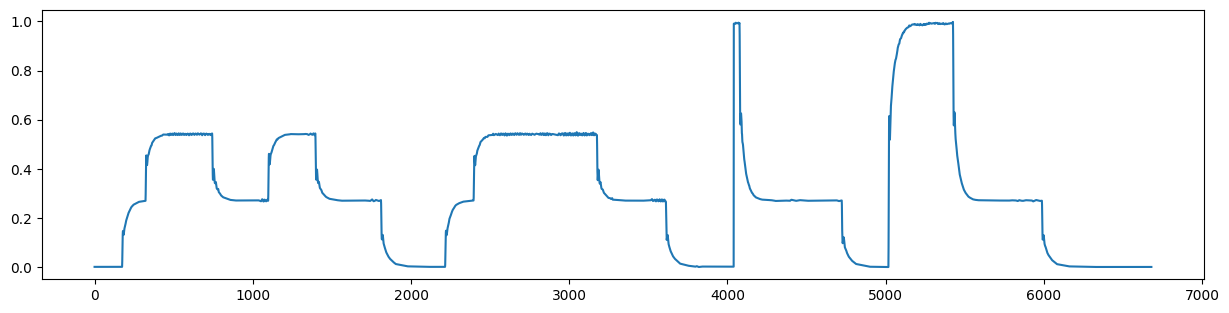

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,3.5))
# plt.plot(Y_test)
# plt.plot(X_test_norm)
plt.plot(Y_test_norm)

# no overlaping split(Nw)  -> stft -> normalize (-1 to 1)



In [ ]:
# import scipy.io as scio
# from pathlib import Path

# files = {
#     'MFP': 'MFP/Training.mat'
# }

# base_dir = Path("..") / "Datasets" / "CVACaseStudy"
# filename = "MFP"

# if filename in files:
#     file_path = base_dir / files[filename]
#     data = scio.loadmat(file_path)
#     data_t1, data_t2, data_t3 = data["T1"], data["T2"], data["T3"]

In [ ]:
# import scipy.io as scio

# files = {
#     'MFP': ['MFP/Training.mat']
# }

# filename = "MFP"
# file = files[filename]
# filepath = "./dataset/"

# if filename == "MFP":
#     data = scio.loadmat(filepath + file[0])
#     data_t1 = data["T1"]
#     data_t2 = data["T2"]
#     data_t3 = data["T3"]


In [ ]:
# data_t1.shape

(10372, 24)

In [ ]:
# train_ratio = 0.6
# valid_ratio = 0.2
# test_ratio = 1 - train_ratio - valid_ratio 

# new_data_train_t1 = data_t1[:int(data_t1.shape[0] * train_ratio)] 
# new_data_train_t2 = data_t2[:int(data_t2.shape[0] * train_ratio)]
# new_data_train_t3 = data_t3[:int(data_t3.shape[0] * train_ratio)]

# new_data_valid_t1 = data_t1[int(data_t1.shape[0] * train_ratio) : int(data_t1.shape[0] * (train_ratio+valid_ratio))] 
# new_data_valid_t2 = data_t2[int(data_t2.shape[0] * train_ratio) : int(data_t2.shape[0] * (train_ratio+valid_ratio))]
# new_data_valid_t3 = data_t3[int(data_t3.shape[0] * train_ratio) : int(data_t3.shape[0] * (train_ratio+valid_ratio))]

# new_data_test_t1 = data_t1[int(data_t1.shape[0] * (train_ratio+valid_ratio)) : data_t1.shape[0]] 
# new_data_test_t2 = data_t2[int(data_t2.shape[0] * (train_ratio+valid_ratio)) : data_t2.shape[0]]
# new_data_test_t3 = data_t3[int(data_t3.shape[0] * (train_ratio+valid_ratio)) : data_t3.shape[0]]

In [ ]:
# import numpy as np 

# training_set = np.vstack((new_data_train_t1,new_data_train_t2,new_data_train_t3))
# validation_set = np.vstack((new_data_valid_t1,new_data_valid_t2,new_data_valid_t3))
# testing_set = np.vstack((new_data_test_t1,new_data_test_t2,new_data_test_t3))

In [ ]:
# output_var = 9
# idx_var_remove = list(set([output_var - 1, -1])) #remove output_var and last variable, ensure that both is different with set()

# X_train = np.delete(training_set,idx_var_remove,axis=1)
# Y_train = training_set[:,output_var-1]

# X_valid = np.delete(validation_set,idx_var_remove,axis=1)
# Y_valid = validation_set[:,output_var-1]

# X_test = np.delete(testing_set,idx_var_remove,axis=1)
# Y_test = testing_set[:,output_var-1]

In [ ]:
# idx_var_remove

[8, -1]

In [ ]:
# Y_test.shape

(6680,)

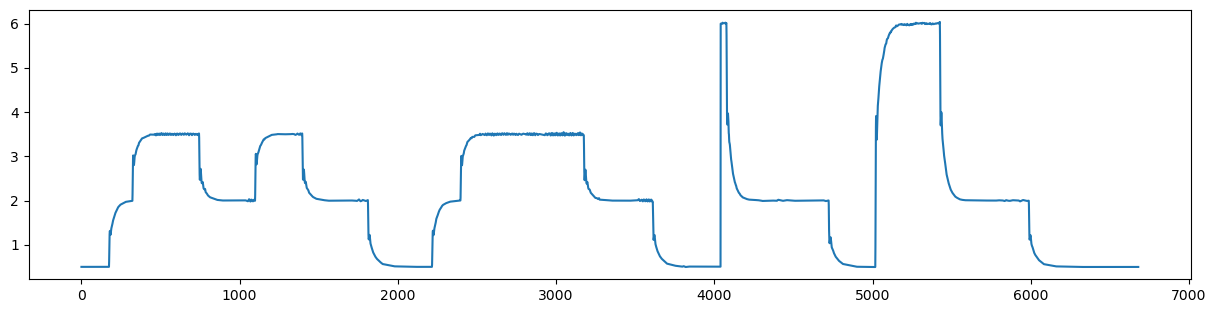

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(15,3.5))
# plt.plot(Y_test)

In [ ]:
# def get_norm_param(X,Y):
#     x = X
#     y = Y

#     keys = ['x_min','x_max','y_min','y_max','x_mean','x_std','y_mean','y_std']
#     norm_param = {}
#     for key in keys: norm_param[key] = []
    
#     norm_param['x_min']  = np.min(x, axis=0)
#     norm_param['x_max']  = np.max(x, axis=0)
#     norm_param['y_min']  = np.min(y, axis=0)
#     norm_param['y_max']  = np.max(y, axis=0)
#     norm_param['x_mean'] = np.mean(x, axis=0)
#     norm_param['x_std']  = np.std(x, axis=0)
#     norm_param['y_mean'] = np.mean(y, axis=0)
#     norm_param['y_std']  = np.std(y, axis=0)

#     return norm_param

# norm_param_train = get_norm_param(X_train,Y_train)

In [ ]:
# def normalize(X,Y,norm_param,method):
#     x = X
#     y = Y

#     if method == 'minmax':
#         X_norm = (x - norm_param['x_min']) / (norm_param['x_max'] - norm_param['x_min'])
#         Y_norm = (y - norm_param['y_min']) / (norm_param['y_max'] - norm_param['y_min'])


#     elif method == 'standardize':
#         X_norm = (x - norm_param['x_mean']) / norm_param['x_std']
#         Y_norm = (y - norm_param['y_mean']) / norm_param['y_std']

#     else:
#         raise TypeError("Normalization Method Not Known")

#     return X_norm, Y_norm

# norm_method = "minmax"
# X_train_norm, Y_train_norm = normalize(X_train,Y_train,norm_param_train,norm_method)
# X_valid_norm, Y_valid_norm = normalize(X_valid,Y_valid,norm_param_train,norm_method)
# X_test_norm, Y_test_norm = normalize(X_test,Y_test,norm_param_train,norm_method)

In [ ]:
# import torch 
# from torch.utils.data import Dataset,DataLoader

# class MyDataset(Dataset):
#     def __init__(self, X, Y, his_length, pred_length, pred_mode):
#         self.x = X
#         self.y = Y
#         self.his_length = his_length 
#         self.pred_length = pred_length
#         self.mode = pred_mode

#     def __getitem__(self,index):

#         x = self.x[index : index + self.his_length]
#         # print(x.shape)

#         if self.mode == 'current_step':
#             y = self.y[index + self.his_length - 1]
#             y = torch.Tensor([y])

#         elif self.mode == 'multi_step':
#             y = self.y[index + self.his_length : index + self.his_length + self.pred_length]
#             y = torch.Tensor(y)

#         else:
#             raise TypeError('Prediction Model is not Known')

#         return torch.Tensor(x), y

#     def __len__(self):
#         if self.mode == 'current_step':
#             return len(self.x) - self.his_length + 1

#         elif self.mode == 'multi_step':
#             return len(self.x) - self.his_length - self.pred_length + 1
        
#         else: 
#             raise TypeError('Prediction Model is not Known')


# pred_mode = 'current_step' # current_step/multi_step
# his_length = 12
# pred_length = 12

# train_dataset = MyDataset(X_train_norm, Y_train_norm, his_length, pred_length, pred_mode)
# valid_dataset = MyDataset(X_valid_norm, Y_valid_norm, his_length, pred_length, pred_mode)
# test_dataset = MyDataset(X_test_norm, Y_test_norm, his_length, pred_length, pred_mode)

In [ ]:
# batch_size = 64

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# for i in train_dataloader:
#     print(i[0].shape)

torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])
torch.Size([64, 12, 22])


In [10]:
from utils import color
color.cprint(f'begin epoch', color.OKBLUE, '\n')
print(f'iters:{1}/{1} loss: 1 speed: {1:5.3f} s/iter')

begin epoch
iters:1/1 loss: 1 speed: 1.000 s/iter


In [11]:
len(train_dataloader)

313